In [74]:
import numpy as np
import h5py
import pandas as pd
from glob import glob
import os
import re
import seaborn as sns 
from glob import glob
import matplotlib.pyplot as plt 
from matplotlib import colors
import matplotlib.ticker as mticker
# settings
color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")
import PyBlastAfterglowMag as PBA
from settings import *
from paths import *
from tqdm import tqdm

import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_170284/1580332650.py:40: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


# Collect data from dirs

In [2]:
sim = SIMULATIONS["SFHo_q125_res150"]
simafgpath = AFGRUNDIR+sim["name"]+"/"
if (not os.path.isdir(simafgpath)):
    raise FileNotFoundError(f"Folder not fould: {simafgpath}")
files = glob(AFGRUNDIR+sim["name"]+"/*/lc_kn.h5")
print(f"Files found: {len(files)}")
print(f"Example: {files[0]}")

Files found: 1920
Example: /media/vsevolod/T7/work/afterglowKentaProject/SFHoTim276_12_15_0025_150mstg_B0_HLLC/kn_nism0001_thetaobs00_p205_epse0001_epsb0001_text25/lc_kn.h5


In [3]:
file0 = h5py.File(files[0],mode="r")
print(file0.keys())
print(file0.attrs.keys())
print(f"Times = {len(np.array(file0['times']))}")
print(f"Freqs = {len(np.array(file0['freqs']))}")
frame = {
    "eps_e":[], "eps_b":[], "n_ism":[], "theta_obs":[], "freq":[], "time":[], "flux":[]
}
for file in tqdm(files):
    workingdir = file.replace("lc_kn.h5","")
    #print(f"Processing {i}/{len(files)}: {workingdir}")
    if not os.path.isdir(workingdir):
        raise FileNotFoundError(f"workingdir not found: {workingdir}")
    pba = PBA.interface.PyBlastAfterglow(workingdir=workingdir,verbose=False)
    times = pba.KN.get_lc_times(spec=False)
    freqs = pba.KN.get_lc_freqs(spec=False,unique=True)
    dfile = pba.KN.get_lc_obj()
    for freq in freqs:
        for time in times:
            flux = pba.KN.get_lc_totalflux(freq=freq,time=time,spec=False)
            for key in frame.keys():
                if (not key in ["time","freq","flux"]):
                    frame[key].append(np.float64(dfile.attrs[key]))    
            frame["time"].append(np.float64(time))
            frame["freq"].append(np.float64(freq))
            frame["flux"].append(np.float64(flux))      

<KeysViewHDF5 ['freqs', 'times', 'total_fluxes']>
<KeysViewHDF5 ['A0', 'Gamma_when_st_starts', 'a', 'd_l', 'eps_b', 'eps_e', 'eps_t', 'fraction_of_Gamma0_when_bm_for_bm', 'freq1', 'freq2', 'im_max_theta', 'iout', 'm_nlayers', 'mfac', 'n_ism', 'n_store_substeps', 'nfreq', 'nlayers', 'nmax', 'nshells', 'ntb', 'p', 'r_ej', 'r_ism', 'rtol', 'rtol_adapt', 's', 'save_dyn_every_it', 'steepnes_of_exp_decay', 'tb0', 'tb1', 'theta_obs', 'which_jet_layer_to_use', 'z']>
Times = 900
Freqs = 900


100%|██████████| 1920/1920 [57:53<00:00,  1.81s/it] 


In [16]:
print(len(frame["eps_b"]))
df = pd.DataFrame.from_dict(frame)


1728000


In [17]:
df.to_csv(simafgpath+"collated.csv")

In [18]:
df = pd.read_csv(simafgpath+"collated.csv",index_col=0)
df.head()

,eps_e,eps_b,n_ism,theta_obs,freq,time,flux
0,0.001,0.001,0.001,0.0,2.400000e+09,100000.000000,4.798325e-08
1,0.001,0.001,0.001,0.0,2.400000e+09,106332.657164,5.439789e-08
2,0.001,0.001,0.001,0.0,2.400000e+09,113066.339795,6.167255e-08
3,0.001,0.001,0.001,0.0,2.400000e+09,120226.443462,6.992121e-08
4,0.001,0.001,0.001,0.0,2.400000e+09,127839.971946,7.926956e-08


In [24]:
eps_e = df["eps_e"].unique()
eps_b = df["eps_b"].unique()
n_ism = df["n_ism"].unique()
theta_obs = df["theta_obs"].unique()
freq = df["freq"].unique()
print(f"eps_e = {len(eps_e)}, eps_b = {len(eps_b)}, n_ism = {len(n_ism)}, theta_obs = {len(theta_obs)}, freq = {len(freq)}")

eps_e = 4, eps_b = 4, n_ism = 4, theta_obs = 6, freq = 6


In [70]:
log_features = ["eps_e","eps_b","n_ism","freq"]
df[log_features] = df[log_features].apply(np.log10)

# collect peak times and peak fluxes
idx = df.groupby(["eps_e","eps_b","n_ism","theta_obs","freq"])["flux"].idxmax()
print(idx)

eps_e     eps_b     n_ism  theta_obs  freq     
-3.00000  -3.00000  -3.0   0.000000   9.380211       14516
                                      9.903090       14666
                                      10.204120      14816
                                      10.431364      14966
                                      10.612784      15116
                                                    ...   
-0.30103  -0.30103   0.0   1.570796   9.903090     1727308
                                      10.204120    1727455
                                      10.431364    1727602
                                      10.612784    1727751
                                      10.968483    1713500
Name: flux, Length: 2304, dtype: int64


In [71]:
max_fluxes = df.loc[idx]
print(max_fluxes.shape)
print(max_fluxes.head())

(2304, 7)
       eps_e  eps_b  n_ism  theta_obs       freq          time          flux
14516   -3.0   -3.0   -3.0        0.0   9.380211  1.239748e+08  1.297027e-06
14666   -3.0   -3.0   -3.0        0.0   9.903090  1.239748e+08  6.298347e-07
14816   -3.0   -3.0   -3.0        0.0  10.204120  1.239748e+08  4.155367e-07
14966   -3.0   -3.0   -3.0        0.0  10.431364  1.239748e+08  3.035731e-07
15116   -3.0   -3.0   -3.0        0.0  10.612784  1.239748e+08  2.362715e-07


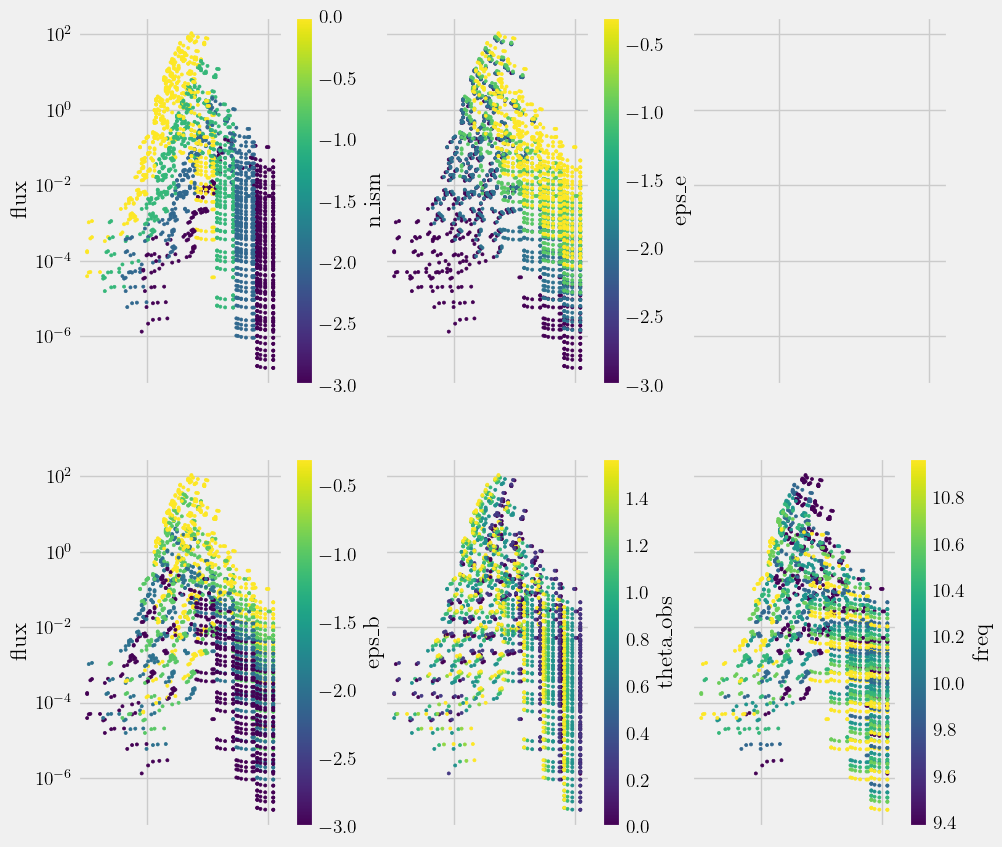

In [72]:
fig,axes = plt.subplots(ncols=3,nrows=2,sharex="all",sharey="all",figsize=(10,10))
max_fluxes.plot.scatter(ax=axes[0][0], x="time",y="flux",c="n_ism",colorbar=True,norm=colors.Normalize(),size=5)
max_fluxes.plot.scatter(ax=axes[0][1], x="time",y="flux",c="eps_e",colorbar=True,norm=colors.Normalize(),size=5)
max_fluxes.plot.scatter(ax=axes[1][0], x="time",y="flux",c="eps_b",colorbar=True,norm=colors.Normalize(),size=5)
max_fluxes.plot.scatter(ax=axes[1][1], x="time",y="flux",c="theta_obs",colorbar=True,norm=colors.Normalize(),size=5)
max_fluxes.plot.scatter(ax=axes[1][2], x="time",y="flux",c="freq",colorbar=True,norm=colors.Normalize(),size=5)
plt.xscale("log")
plt.yscale("log")
plt.show()

#### Mutual information (MI) 
between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?  
MI is univariate metric

In [106]:
def make_mi_scores(X : pd.DataFrame, y : np.array, discrete_features):
    mi_scores = mutual_info_regression(X,y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [107]:
features = ["eps_e","eps_b","n_ism","theta_obs"]#"freq"]

MI scores for Time
eps_e        0.000266
eps_b        0.000000
n_ism        0.000000
theta_obs    0.000000
Name: MI Scores, dtype: float64


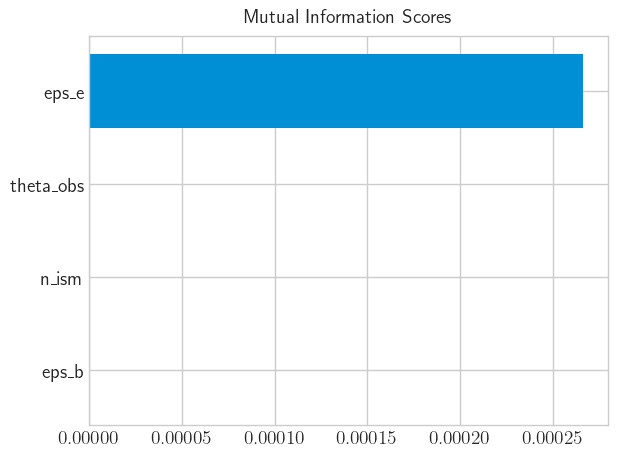

In [108]:
X = df.copy()
y = X.pop("time")
X = X.loc[:,features]
mi_scores = make_mi_scores(X,y,None)
print(f"MI scores for Time")
print(mi_scores)
plot_mi_scores(mi_scores)
plt.show()


MI scores for Flux
eps_b        0.150907
n_ism        0.143763
eps_e        0.104787
theta_obs    0.058155
Name: MI Scores, dtype: float64


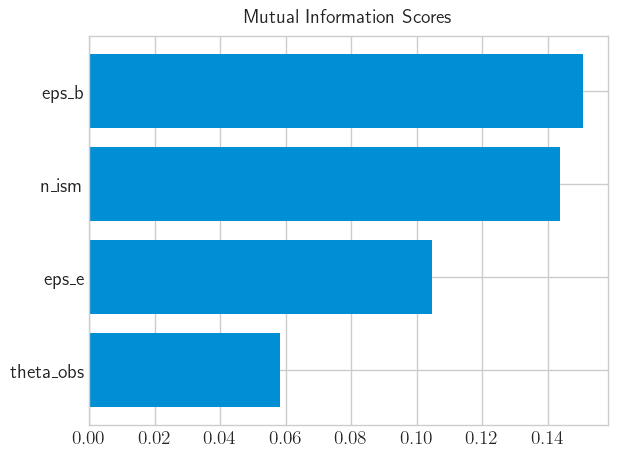

In [109]:
X = df.copy()
y = X.pop("flux")
X = X.loc[:,features]
mi_scores = make_mi_scores(X,y,None)
print(f"MI scores for Flux")
print(mi_scores)
plot_mi_scores(mi_scores)
plt.show()

In [110]:
print(df.isnull().sum())
print(df.isna().sum())
from sklearn.decomposition import PCA
print(df.keys())

eps_e        0
eps_b        0
n_ism        0
theta_obs    0
freq         0
time         0
flux         0
dtype: int64
eps_e        0
eps_b        0
n_ism        0
theta_obs    0
freq         0
time         0
flux         0
dtype: int64
Index(['eps_e', 'eps_b', 'n_ism', 'theta_obs', 'freq', 'time', 'flux'], dtype='object')


RF train accuracy: 0.143


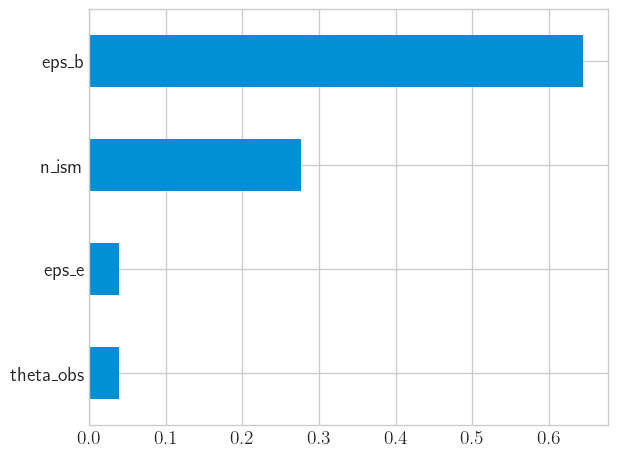

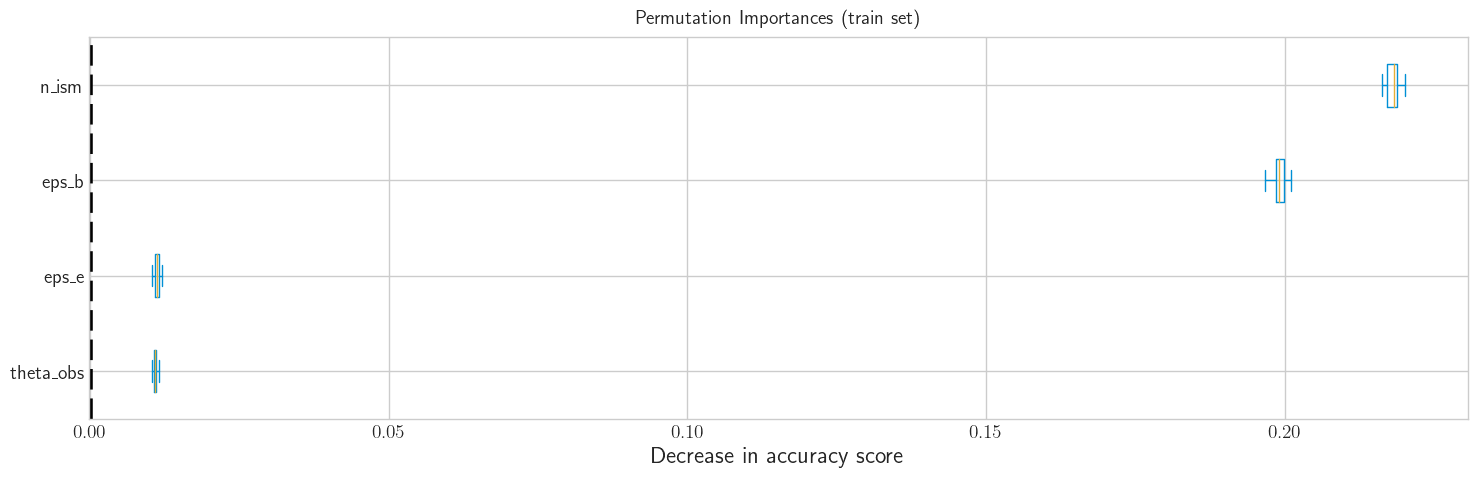

In [114]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split

rf = RandomForestRegressor(
         n_estimators=100,
         n_jobs=-1,
         min_samples_leaf = 1,
         oob_score=True,
         random_state = 42)
X = df.copy()
y = X.pop("flux")
X = X.loc[:,features]
_X = np.array(X)
_y = np.array(y)
rf.fit(_X, _y)
print(f"RF train accuracy: {rf.score(_X, _y):.3f}")
feat_importances = pd.Series(rf.feature_importances_, index = X.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh')
plt.show()

from sklearn.inspection import permutation_importance
#calculate permutation importance for training data 
result_train = permutation_importance(
    rf, _X, _y, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train].T,
    columns=X.columns[sorted_importances_idx_train],
)

f, axs = plt.subplots(1,1,figsize=(15,5))
importances_train.plot.box(vert=False, whis=10, ax = axs)
axs.set_title("Permutation Importances (train set)")
axs.axvline(x=0, color="k", linestyle="--")
axs.set_xlabel("Decrease in accuracy score")
axs.figure.tight_layout()
plt.show()


RF train accuracy: -0.000


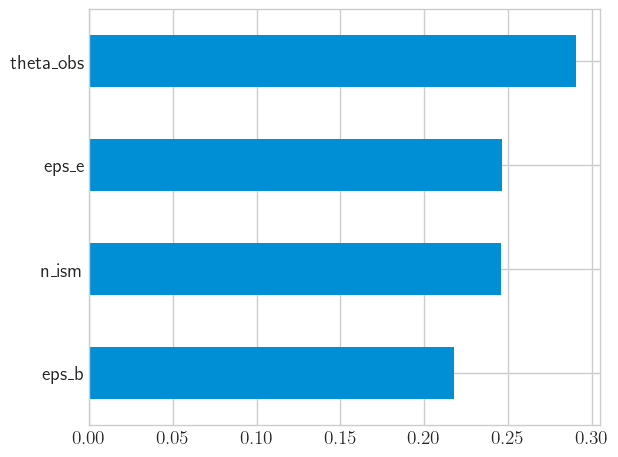

In [112]:
rf = RandomForestRegressor(
         n_estimators=100,
         n_jobs=-1,
         min_samples_leaf = 1,
         oob_score=True,
         random_state = 42)
X = df.copy()
y = X.pop("time")
X = X.loc[:,features]
_X = np.array(X)
_y = np.array(y)
rf.fit(_X, _y)
print(f"RF train accuracy: {rf.score(_X, _y):.3f}")
feat_importances = pd.Series(rf.feature_importances_, index = X.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh')
plt.show()

### On the importance of permutation:
Default feature importances are not accurate when you have an overfitting.  
Impurity-based importances are biased towards high-cardinality and numerical features.
When a model overfits, it picks up too much noise from the training set to make generalized predictions on the test set. When this happens, the feature importances are not reliable as they are calculated based on the training set.   
See also Bias in random forest variable importance measures (Strobl et al)